# Financial News Sentiment Analysis

by Nick Pham

This project focuses on predicting sentiment in text from financial news using natural language processing (NLP) and logistic regression. The workflow includes cleaning and preprocessing text data, visualizing sentiment distribution and word count trends, and analyzing word usage across unigrams, bigrams, and n-grams using word clouds. TF-IDF–based logistic regression models are trained to classify sentiment, with performance evaluated through confusion matrices, classification report heatmaps, and SHAP plots to visualize influential words and phrases.

# Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import string
import re
import shap
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

In [2]:
# Load the dataset from Hugging Face with their library
dataset = load_dataset("takala/financial_phrasebank", "sentences_allagree", trust_remote_code=True)

# Convert to a Pandas DataFrame
df = dataset["train"].to_pandas()

# About the Data

**Dataset**: Financial Phrasebank  
**Authors**: Pekka Malo, Ankur Sinha, Panu Korhonen, Jyrki Wallenius, and Peter Takala  
**Source**: [Hugging Face Dataset Repository](https://huggingface.co/datasets/takala/financial_phrasebank)  
**License**: Creative Commons Attribution-NonCommercial-ShareAlike 3.0 Unported (CC BY-NC-SA 3.0)  
**Reference**: Malo, P., Sinha, A., Korhonen, P., Wallenius, J., & Takala, P. (2014). *Good debt or bad debt: Detecting semantic orientations in economic texts*. Journal of the Association for Information Science and Technology, 65(4), 782–796.

The data contains sentences and labels from financial news. Labels take on values of (0, 1, 2) which represent (negative, neutral, positive). The labels are annotated by 8 people. The dataset used is the all_agree dataset, where all annotators agree on the same sentiment that the sentence takes.

# Data Cleaning

## Missing Values

In [3]:
# Check for missing values
df.isna().sum()

sentence    0
label       0
dtype: int64

There are no missing values in the dataset.

## Data Types

In [4]:
# Check data types of each column
df.dtypes

sentence    object
label        int64
dtype: object

Data types are appropriate for the data. Sentences are objects, which are appropriate for text and labels are integers.

## Duplicates

In [5]:
# Check for duplicates
duplicate = df[df.duplicated(subset="sentence", keep=False)]

# Print the resultant Dataframe
duplicate

,sentence,label
518,The issuer is solely responsible for the conte...,1
519,The issuer is solely responsible for the conte...,1
625,The report profiles 614 companies including ma...,1
626,The report profiles 614 companies including ma...,1
928,Ahlstrom 's share is quoted on the NASDAQ OMX ...,1
929,Ahlstrom 's share is quoted on the NASDAQ OMX ...,1
1026,SSH Communications Security Corporation is hea...,1
1027,SSH Communications Security Corporation is hea...,1
1408,The company serves customers in various indust...,1
1409,The company serves customers in various indust...,1


The data does appear to have some duplicate rows. They can be handled using the df.drop_duplicates() function.

In [6]:
# Drop Duplicates
df = df.drop_duplicates().copy()
df[df.duplicated(subset="sentence", keep=False)]

,sentence,label


Duplicates have been completely handled.

## Text Cleaning

In [7]:
# Download required resources
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("punkt_tab", quiet=True)

# Define stopwords
stop_words = set(stopwords.words("english"))

def clean_text(text):
    # Preserve hyphens, remove other punctuation (excluding slashes if needed)
    text = re.sub(r"[^\w\s\-]", "", text)  # preserves hyphens
    
    # Insert space around hyphens that are not part of meaningful compounds
    text = re.sub(r"\s*-\s*", " ", text)
    
    # Lowercase
    text = text.lower()
    
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    return " ".join(tokens)

# Apply text cleaning function
df["cleaned_sentence"] = df["sentence"].apply(clean_text)

# Tokenize and count words
df["cleaned_word_count"] = df["cleaned_sentence"].str.split().str.len()

In [8]:
# Apply text cleaning function
df["cleaned_sentence"] = df["sentence"].apply(clean_text)

# Tokenize and count words
df["cleaned_word_count"] = df["cleaned_sentence"].str.split().str.len()

## Add sentiment labels

In [9]:
# Map labels to dummy variables
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
df["sentiment"] = df["label"].map(label_map)

In [10]:
# Print the dataframe
df

,sentence,label,cleaned_sentence,cleaned_word_count,sentiment
0,"According to Gran , the company has no plans t...",1,according gran company plans move production r...,10,Neutral
1,"For the last quarter of 2010 , Componenta 's n...",2,last quarter 2010 componenta net sales doubled...,21,Positive
2,"In the third quarter of 2010 , net sales incre...",2,third quarter 2010 net sales increased 52 eur ...,16,Positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,operating profit rose eur 131 mn eur 87 mn cor...,16,Positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,operating profit totalled eur 211 mn eur 186 m...,14,Positive
...,...,...,...,...,...
2259,Operating result for the 12-month period decre...,0,operating result 12 month period decreased pro...,15,Negative
2260,HELSINKI Thomson Financial - Shares in Cargote...,0,helsinki thomson financial shares cargotec fel...,27,Negative
2261,LONDON MarketWatch -- Share prices ended lower...,0,london marketwatch share prices ended lower lo...,17,Negative
2262,Operating profit fell to EUR 35.4 mn from EUR ...,0,operating profit fell eur 354 mn eur 688 mn 20...,17,Negative


# Exploratory Data Analysis

## Sentiment Distribution

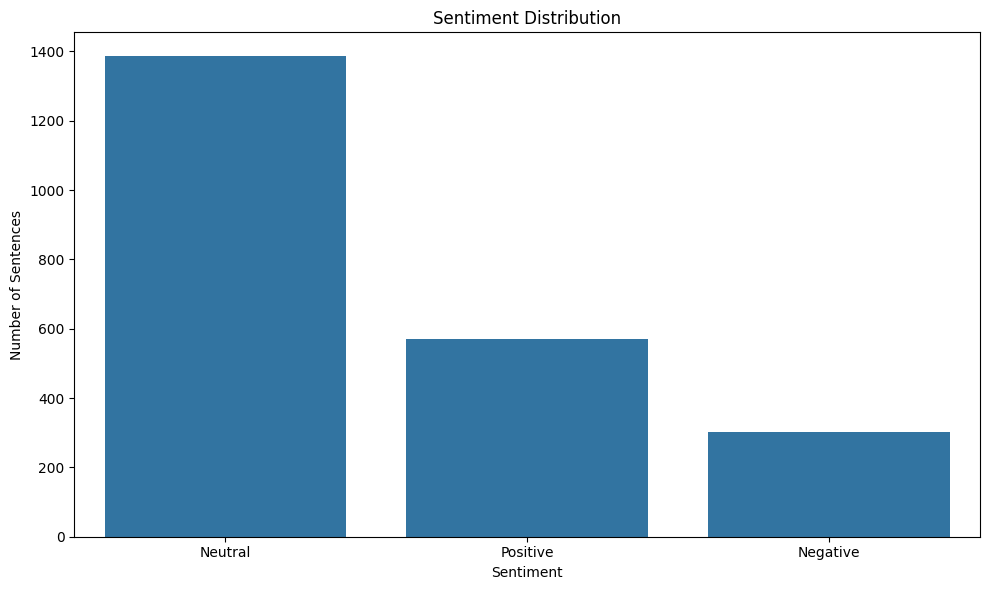

In [11]:
# Count sentiment types
sentiment_counts = df["sentiment"].value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Sentences")
plt.tight_layout()
plt.savefig('sentiment_visuals/sentiment_distribution')
plt.show()

- It looks like most over half of the sentiment in the data is labeled as neutral. 
- Positive sentiment is around double the negative sentiment. 
- The data is imbalanced and sentiment prediction models are suceptible to biases toward neutral sentiment.

## Word Count Distribution by Sentiment

### Uncleaned Text

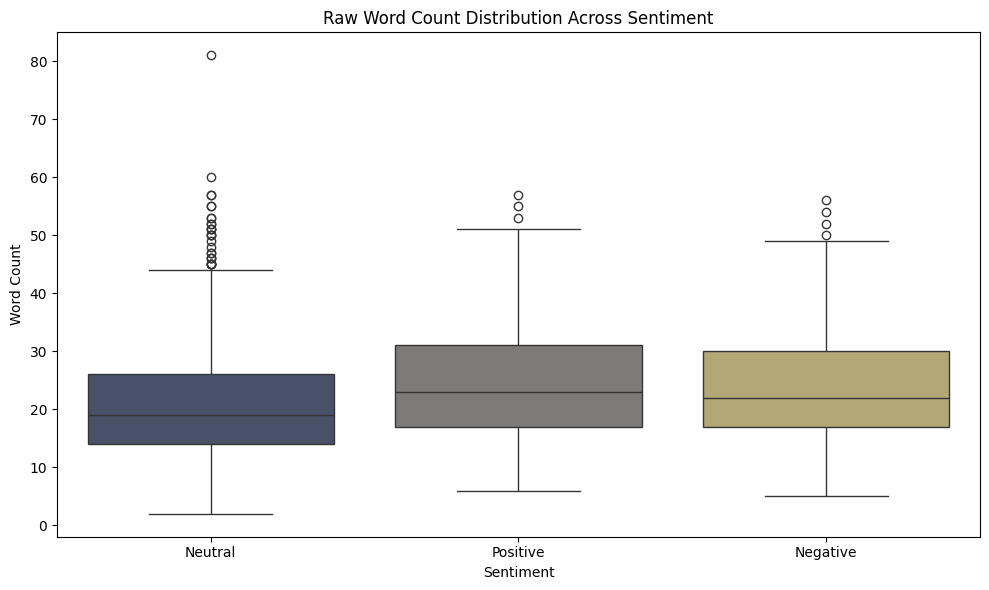

In [12]:
# Tokenize and count words
df["word_count"] = df["sentence"].str.split().str.len() # Uses raw text

# Word Count Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="sentiment", y="word_count", hue = "sentiment", palette="cividis")
plt.title("Raw Word Count Distribution Across Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Word Count")
plt.tight_layout()
plt.savefig("sentiment_visuals/word_count_dist_uncleaned")
plt.show()

- Word count is slightly higher when sentiment is positive vs negative, but the difference is small.
- When sentiment is neutral, word count tends to be the lowest.
- Neutral sentiment also has the most outliers in word count.
- Positive sentiment seems to have a larger box than negative sentiment, indicating larger spread in word count.
- In the context of the data, financial news tends to have longer sentences when sentiment has a clear direction.
- For all sentiment classes, the data seems to be skewed towards higher word counts since the line representing the median is below the center of each box.

### Cleaned Text

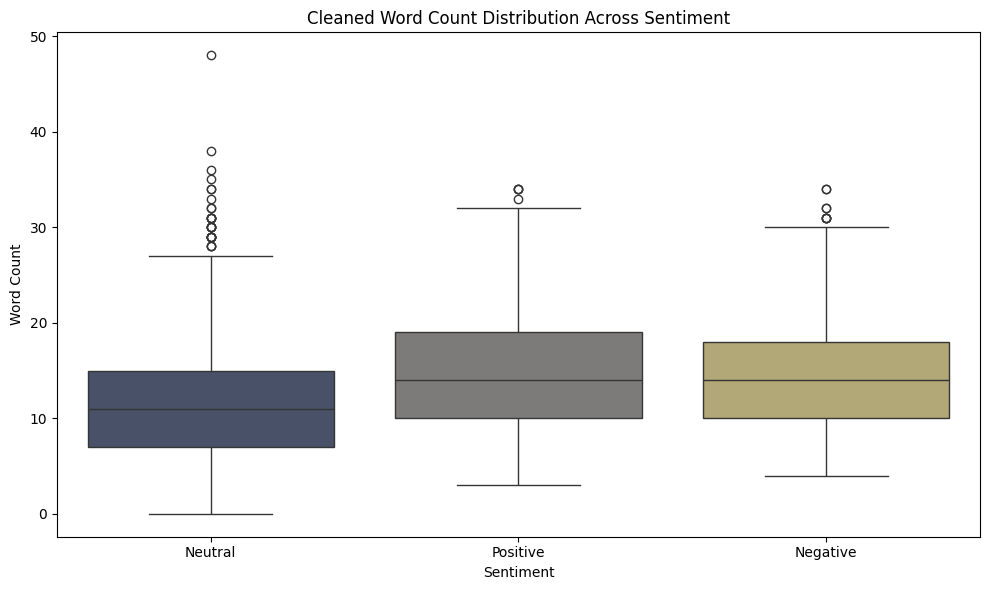

In [13]:
# Tokenize and count words
df["word_count_cleaned"] = df["cleaned_sentence"].str.split().str.len() # Uses cleaned text

# Word Count Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="sentiment", y="word_count_cleaned", hue = "sentiment", palette="cividis")
plt.title("Cleaned Word Count Distribution Across Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Word Count")
plt.tight_layout()
plt.savefig("sentiment_visuals/word_count_dist_cleaned")
plt.show()

- After cleaning the text and removing stopwords, the boxes for each sentiment are now lower. 
- The previous pattern of positive > negative > neutral in word count is observed again.
- Skew seems to become more obvious for positive and negative sentiment (the median line is closer to the bottom of the box).
- For neutral sentiment, the median line approaches the middle of the box indicating reduced skew.
- The box for positive sentiment appears larger indicating wider spread in word count.

## Top Words/Phrases

Term Frequency Inverse Document Frequency (TF-IDF) will be used to vectorize and weigh the text. Term Frequency measures the number of occurances of a term, while Inverse Document Frequency penalizes terms that appear across many documents. TF-IDF combines both methods, emphasizing terms that are frequent but uniquely distributed across different observations. Scores represent discriminatory power and are distinct to each sentiment class if the text appears across multiple sentiments.

### Top Words by Sentiment

In [14]:
# Group sentences by sentiment
grouped = df.groupby("sentiment")["cleaned_sentence"].apply(lambda x: " ".join(x))

# Vectorize with TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf.fit_transform(grouped)
feature_names = tfidf.get_feature_names_out()

# Top words per sentiment
for idx, sentiment in enumerate(grouped.index):
    row = tfidf_matrix[idx].toarray()[0]
    top_indices = row.argsort()[-10:][::-1]
    top_words = [(feature_names[i], round(row[i], 3)) for i in top_indices]
    print(f"\n Top 10 words for {sentiment}:")
    for word, score in top_words:
        print(f" - {word}: {score}")


 Top 10 words for Negative:
 - eur: 0.564
 - mn: 0.418
 - profit: 0.274
 - net: 0.189
 - sales: 0.162
 - quarter: 0.16
 - year: 0.16
 - operating: 0.153
 - decreased: 0.151
 - mln: 0.139

 Top 10 words for Neutral:
 - company: 0.37
 - eur: 0.216
 - finland: 0.179
 - shares: 0.174
 - business: 0.161
 - group: 0.154
 - million: 0.151
 - services: 0.136
 - share: 0.126
 - said: 0.119

 Top 10 words for Positive:
 - eur: 0.531
 - mn: 0.316
 - profit: 0.243
 - net: 0.235
 - year: 0.219
 - rose: 0.197
 - sales: 0.183
 - period: 0.177
 - million: 0.167
 - finnish: 0.153


A number of top words aren't very meaningful for sentiment analysis. Aside from a handle of words like decreased or rose, most of the top words don't imply any clear sentiment. To find more meaningful text that contributes to each sentiment, custom stopwords can be excluded and we can examine top phrases instead of words.

### Filtered Top Words by Sentiment

In [15]:
# Add custom stopwords
custom_stopwords = list([
    "mn", "mln", "000", "st", "petersburg", "said", "group", "eur0",
    "yearonyear", "omx", "hk", "ruokatalo", "stora", "enso", "oyj", "hel",
    "eur", "company", "also", "includes", "finnish", "finland"
])

In [16]:
# Group sentences by sentiment
grouped = df.groupby("sentiment")["cleaned_sentence"].apply(lambda x: " ".join(x))

# Vectorize Unigram with TF-IDF
tfidf = TfidfVectorizer(stop_words=custom_stopwords, max_features=1000, ngram_range=(1, 1))
tfidf_matrix = tfidf.fit_transform(grouped)
feature_names = tfidf.get_feature_names_out()

# Find Top words for each sentiment
for idx, sentiment in enumerate(grouped.index):
    row = tfidf_matrix[idx].toarray()[0]
    top_indices = row.argsort()[-10:][::-1]
    top_words = [(feature_names[i], round(row[i], 3)) for i in top_indices]
    print(f"\n Top 10 words for {sentiment}:")
    for word, score in top_words:
        print(f" - {word}: {score}")


 Top 10 words for Negative:
 - profit: 0.41
 - net: 0.282
 - sales: 0.242
 - quarter: 0.239
 - year: 0.239
 - operating: 0.228
 - decreased: 0.225
 - 2008: 0.205
 - period: 0.195
 - million: 0.191

 Top 10 words for Neutral:
 - shares: 0.207
 - business: 0.191
 - million: 0.179
 - services: 0.162
 - share: 0.15
 - market: 0.12
 - sales: 0.118
 - new: 0.116
 - value: 0.116
 - 2007: 0.116

 Top 10 words for Positive:
 - profit: 0.337
 - net: 0.325
 - year: 0.303
 - rose: 0.272
 - sales: 0.252
 - period: 0.245
 - million: 0.231
 - operating: 0.202
 - increased: 0.186
 - quarter: 0.174


Adding custom stopwords removed some currencies and got a few more meaningful words, but most of the words still don't indicate clear sentiment.

### Filtered Top Bigrams

By limiting to phrases, there will be increased precision and sentiment may be better captured. Bigrams can represent 2 letters, syllables, or words. In this project, bigrams will represent 2 word phrases.

In [17]:
# Vectorize Bigram with TF-IDF
tfidf_2 = TfidfVectorizer(stop_words=custom_stopwords, max_features=3000, ngram_range=(2, 2)) # lists 2 word phrases
X_2 = tfidf_2.fit_transform(df["cleaned_sentence"])
feature_names_2 = tfidf_2.get_feature_names_out()

# Create TF-IDF DataFrame for the Bigrams
tfidf_df2 = pd.DataFrame(X_2.toarray(), columns=feature_names_2)
tfidf_df2["sentiment"] = df["sentiment"]

# Group by sentiment and compute mean TF-IDF scores for the Bigrams
avg_tfidf_2 = tfidf_df2.groupby("sentiment").mean(numeric_only=True)

# Show top Bigrams for each sentiment
for sentiment in avg_tfidf_2.index:
    top_words_2 = avg_tfidf_2.loc[sentiment].sort_values(ascending=False).head(10)
    print(f"\n Top 10 bigrams for {sentiment}:")
    for word, score in top_words_2.items():
        print(f" - {word}: {round(score, 3)}")


 Top 10 bigrams for Negative:
 - operating profit: 0.042
 - net sales: 0.031
 - corresponding period: 0.026
 - sales decreased: 0.025
 - net profit: 0.022
 - profit fell: 0.022
 - year earlier: 0.022
 - third quarter: 0.02
 - first half: 0.02
 - compared profit: 0.019

 Top 10 bigrams for Neutral:
 - net sales: 0.008
 - voting rights: 0.006
 - board directors: 0.005
 - value order: 0.005
 - share capital: 0.005
 - per share: 0.004
 - value contract: 0.004
 - financial details: 0.004
 - stock exchange: 0.004
 - total value: 0.003

 Top 10 bigrams for Positive:
 - operating profit: 0.052
 - net sales: 0.035
 - profit rose: 0.028
 - corresponding period: 0.028
 - net profit: 0.02
 - per share: 0.017
 - year year: 0.016
 - year earlier: 0.015
 - third quarter: 0.013
 - period 2006: 0.013


The new set, consisting of phrases appears more meaningful compared to the previouis set of words. 'Profit rose' for example, more clearly indicates sentiment than having the words profit or rose by themselves. The combination of 'period' and 'quarter' with numerical years indicate more precise time periods. The TF-IDF scores are noticeably lower, which is a normal occurance as phrases appear less frequently than words.

### Filtered N-Grams (3-5 Words)

N-grams can represent a range of words, syllables, or letters. Let's generate look at an N-Gram with 3-5 words.

In [18]:
# Vectorize N-Grams with TF-IDF
tfidf_3 = TfidfVectorizer(stop_words=custom_stopwords, max_features=3000, ngram_range=(3, 5), lowercase=False)
X_3 = tfidf_3.fit_transform(df["cleaned_sentence"])
feature_names_3 = tfidf_3.get_feature_names_out()

# Create TF-IDF DataFrame for the N-Grams
tfidf_df3 = pd.DataFrame(X_3.toarray(), columns=feature_names_3)
tfidf_df3["sentiment"] = df["sentiment"]

# Group by sentiment and compute mean TF-IDF scores for the N-Grams
avg_tfidf_3 = tfidf_df3.groupby("sentiment").mean(numeric_only=True)

# Show top N-Grams for each sentiment
for sentiment in avg_tfidf_3.index:
    top_words_3 = avg_tfidf_3.loc[sentiment].sort_values(ascending=False).head(10)
    print(f"\n Top 10 N-Grams for {sentiment}:")
    for word, score in top_words_3.items():
        print(f" - {word}: {round(score, 3)}")


 Top 10 N-Grams for Negative:
 - operating profit fell: 0.018
 - net sales decreased: 0.016
 - non recurring items: 0.013
 - corresponding period 2008: 0.012
 - operating loss totalled: 0.012
 - operating profit totalled: 0.011
 - first quarter 2008: 0.011
 - operating profit excluding: 0.011
 - operating profit decreased: 0.01
 - pretax profit decreased: 0.01

 Top 10 N-Grams for Neutral:
 - capital voting rights: 0.003
 - share capital voting rights: 0.003
 - share capital voting: 0.003
 - annual general meeting: 0.002
 - nordic exchange helsinki: 0.002
 - listed nordic exchange helsinki: 0.002
 - listed nordic exchange: 0.002
 - shares voting rights: 0.002
 - nokia siemens networks: 0.002
 - total value contract: 0.002

 Top 10 N-Grams for Positive:
 - operating profit rose: 0.024
 - corresponding period 2005: 0.012
 - corresponding period 2006: 0.012
 - earnings per share: 0.012
 - net sales increased: 0.01
 - net profit rose: 0.01
 - corresponding period 2009: 0.009
 - operating 

After the changes, the phrases are even more meaningful. The TF-IDF scores have dropped even further when looking for the N-Grams. This is a tradeoff that comes with the enhanced precision from targeting prases over single words and increasing the length of the phrases being targeted.

## Word Clouds

### Unigram Word Cloud

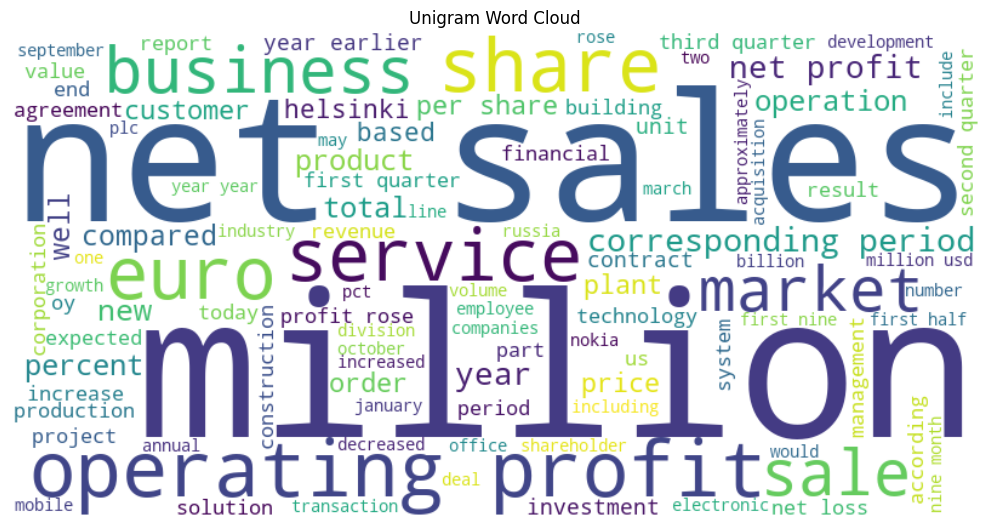

In [19]:
# Combine all sentences into one string
text = " ".join(df["cleaned_sentence"].astype(str).tolist())

# Generate the Unigram Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=custom_stopwords,
    max_words=100,
    colormap="viridis"
).generate(text)

# Plot Unigram Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Unigram Word Cloud")
plt.tight_layout()
plt.savefig('sentiment_visuals/unigram_wordcloud')
plt.show()

- Financial currencies and business terms appear frequently.
- The data seems to be dominantly based around European companies and/or news since euro appears most frequently, although usd has also appeared in the wordcloud.
- From the size of the words, the news mentions sales, profits, and million most frequently.
- However, with single words it can be difficult to identify sentiment. Words like 'increase' or 'fell' could be used describe to either profits or losses.

### Bigram Word Cloud

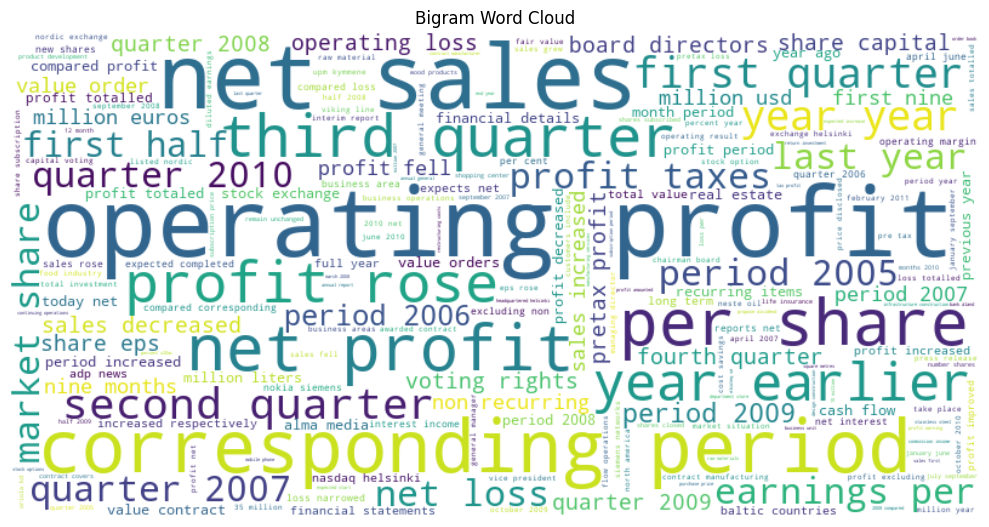

In [20]:
# Sum TF-IDF scores  for Bigrams
tfidf_2_scores = X_2.sum(axis=0).A1
freq_dict_2 = dict(zip(feature_names_2, tfidf_2_scores))

# Generate the Bigram Word Cloud
wordcloud_2 = WordCloud(
    width=800, 
    height=400, 
    background_color="white", 
    collocations=False).generate_from_frequencies(freq_dict_2)

# Plot Bigram Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_2, interpolation="bilinear")
plt.axis("off")
plt.title("Bigram Word Cloud")
plt.tight_layout()
plt.savefig('sentiment_visuals/bigram_wordcloud')
plt.show()

- With Bigrams, the word cloud contains 2 word phrases instead.
- The biggest change in this word cloud are the temporal anchors and directional signals such as more specific time periods and whether profit increased or decreased.
- Other financial terms like cash flow and voting rights can now be captured.

### N-Gram (3-5) Word Cloud

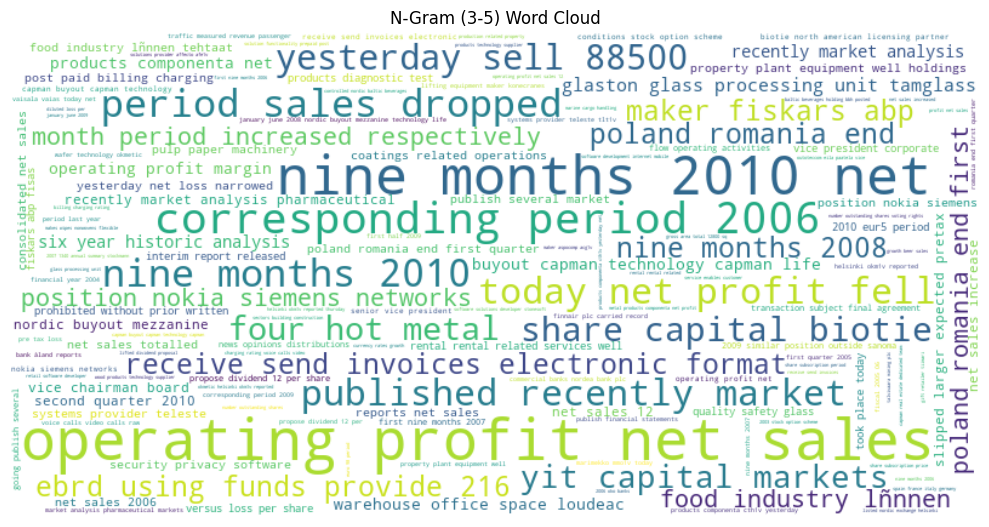

In [21]:
# Sum TF-IDF scores for N-Grams
tfidf_3_scores = X_2.sum(axis=0).A1
freq_dict_3 = dict(zip(feature_names_3, tfidf_3_scores))

# Generate N-Grams Word Cloud
wordcloud_n = WordCloud(
    width=800, 
    height=400, 
    background_color="white", 
    collocations=False).generate_from_frequencies(freq_dict_3)

# Trim the dictionary to truncate phrases
trimmed_dict = {
    k: v for k, v in freq_dict_3.items() if len(k) < 40
}

wordcloud_n.generate_from_frequencies(trimmed_dict)

# Plot N-Grams Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_n, interpolation="bilinear")
plt.axis("off")
plt.title("N-Gram (3-5) Word Cloud")
plt.tight_layout()
plt.savefig('sentiment_visuals/n-gram_wordcloud')
plt.show()

- Seems more sparse compared to the Bigram Word Cloud
- Captures much richer context such as 'today net profit fell' and longer phrases like 'recent market analysis'. 

# Sentiment Classification Models

The models will use TF-IDF vectorization combined with a logistic regression classifier.

The TF-IDF vectorizer converts text to numerical features and inputs those into a logistic regression classification algorithm, which finds the probabilities for each sentiment class and chooses the sentiment with the highest probability as its prediction.

## Unigram

### Model Pipeline

In [22]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(df["cleaned_sentence"], df["label"], test_size=0.3, random_state=42)

# Build the Unigram Model Pipeline
model_unigram = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words=custom_stopwords, max_features=3000, ngram_range=(1, 1))),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced")) # weight applied since data is imbalanced
])

# Fit the Unigram Model
model_unigram.fit(X_train, y_train)

# Make predictions with the Unigram Model
y_pred_unigram = model_unigram.predict(X_test)

### Classification Report

Since sentiment prediction is a classification task, the metrics used for model validation will include precision, recall, f1-score, and accuracy.

In [23]:
# Classification Report
print(classification_report(y_test, y_pred_unigram, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.62      0.65      0.64        86
     Neutral       0.88      0.96      0.92       411
    Positive       0.81      0.61      0.70       181

    accuracy                           0.83       678
   macro avg       0.77      0.74      0.75       678
weighted avg       0.83      0.83      0.82       678



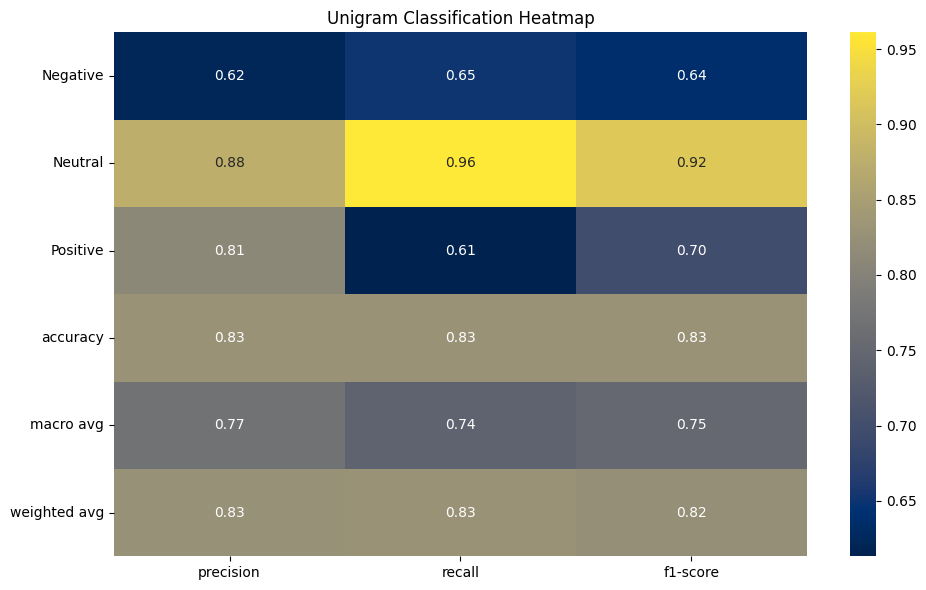

In [24]:
# Save Classification Report as dataframe and transpose
report_dict = classification_report(y_test, y_pred_unigram, target_names=["Negative", "Neutral", "Positive"], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Drop support column
report_df = report_df.drop(columns=["support"])

# Construct the Unigram Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap="cividis", fmt=".2f")
plt.title("Unigram Classification Heatmap")
plt.tight_layout()
plt.savefig("sentiment_visuals/unigram_classification_heatmap")
plt.show()

The unigram model has excellent performance for neutral sentiment, but performs poorly with other sentiment. Overall, the model has good accuracy, but it is biased towards neutral sentiment. 

### Confusion Matrix

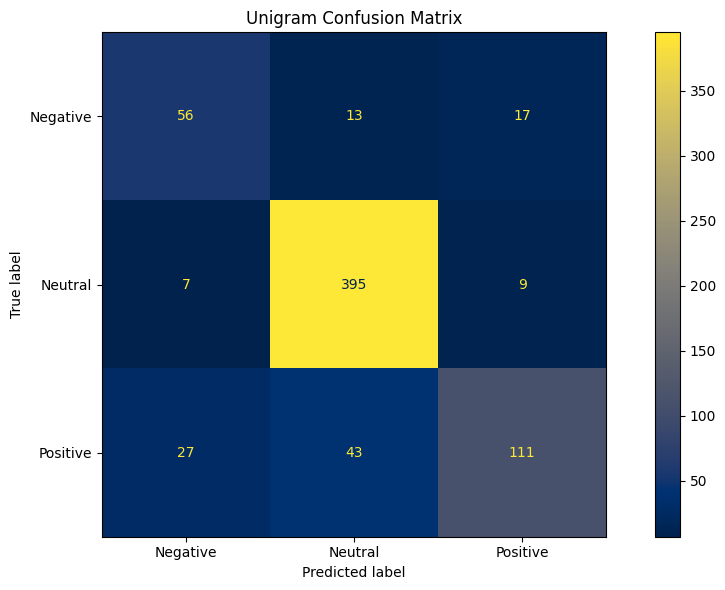

In [25]:
# Create the Unigram Confusion Matrix
cm = confusion_matrix(y_test, y_pred_unigram)
fig, ax = plt.subplots(figsize=(10,6))

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Negative", "Neutral", "Positive"])

# Construct the Unigram Confusion Matrix
disp.plot(cmap="cividis", ax=ax)
plt.title("Unigram Confusion Matrix")
plt.tight_layout()
plt.savefig("sentiment_visuals/unigram_confusion_matrix")
plt.show()

This confusion matrix highlights the unigram model’s strength in identifying neutral sentiment. However, recall for negative and positive sentiments remains limited, reflecting the challenge of capturing polarity with single-word features. Misclassifications between positive and negative classes indicate a need for richer context modeling.

### SHAP Visualization

Machine learning models are often black boxes. They may produce metrics, but how and why they make their predictions under the hood isn't always clear. Computation and interpretation of SHAP (SHapley Additive exPlanations) values is one method used to explain the output of a machine learning model.

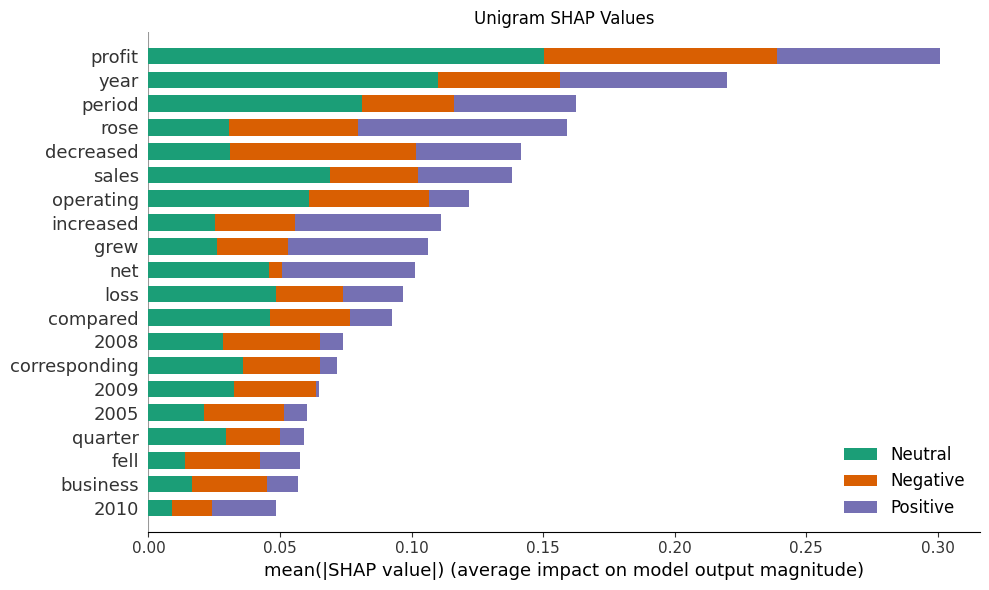

In [26]:
# Transform X_test
X_test_transformed = model_unigram.named_steps["tfidf"].transform(X_test)

# Compute Unigram SHAP values
explainer_unigram = shap.Explainer(model_unigram.named_steps["clf"], X_test_transformed)
shap_values = explainer_unigram(X_test_transformed)

# Visualize the Unigram SHAP values
shap.summary_plot(shap_values, 
                  features=X_test_transformed, 
                  feature_names=model_unigram.named_steps["tfidf"].get_feature_names_out(),
                  class_names=["Negative", "Neutral", "Positive"],
                  color=plt.get_cmap("Dark2"),
                  show=False)

plt.gcf().set_size_inches(10, 6)
plt.title("Unigram SHAP Values")
plt.tight_layout()
plt.savefig("sentiment_visuals/unigram_shap")
plt.show()

- Words like rose, fell, increased, and decreased, are directional indicators, but lack context.
- Profit, sales, and eps are financial metrics frequent used to assess business performance and are strongly tied to sentiment.
- Words like 2008, quarter, and year often lean towards neutral or negative. Their influence may reflect historical comparisons that  tends to skew sentiment downwards. Perhaps the news documented poorer financials than those time periods.

## Bigram

### Model Pipeline

In [27]:
# Build the Bigram Model Pipeline
model_bigram = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=3000, stop_words=custom_stopwords, ngram_range=(2, 2))),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced")) # weight applied since data is imbalanced
])

# Fit the Bigram Model
model_bigram.fit(X_train, y_train)

# Make predictions with the Bigram Model
y_pred_bigram = model_bigram.predict(X_test)

### Classification Report

In [28]:
# Classification Report
print(classification_report(y_test, y_pred_bigram, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.57      0.48      0.52        86
     Neutral       0.85      0.96      0.90       411
    Positive       0.73      0.56      0.63       181

    accuracy                           0.79       678
   macro avg       0.71      0.67      0.68       678
weighted avg       0.78      0.79      0.78       678



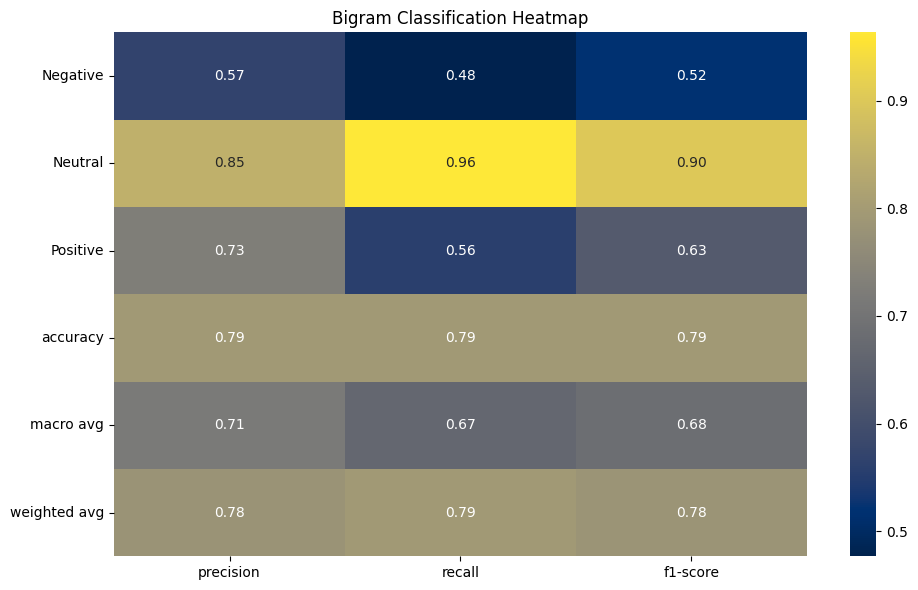

In [29]:
# Save Classification Report as dataframe and transpose
report_dict_bigram = classification_report(y_test, y_pred_bigram, target_names=["Negative", "Neutral", "Positive"], output_dict=True)
report_df_bigram = pd.DataFrame(report_dict_bigram).transpose()

# Drop support column
report_df_bigram = report_df_bigram.drop(columns=["support"])

# Construct the Bigram Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df_bigram, annot=True, cmap="cividis", fmt=".2f")
plt.title("Bigram Classification Heatmap")
plt.tight_layout()
plt.savefig("sentiment_visuals/bigram_classification_heatmap")
plt.show()

- Overall, the Bigram model has poorer performance than the unigram model.
- While Bigrams may capture more context, the precision, recall, and f1-score all decreased for positive and negative sentiment.
- The model makes fewer correct predictions and has poorer balance between precision and recall.
- Metrics for neutral sentiment remain about the same as the unigram model.

### Confusion Matrix

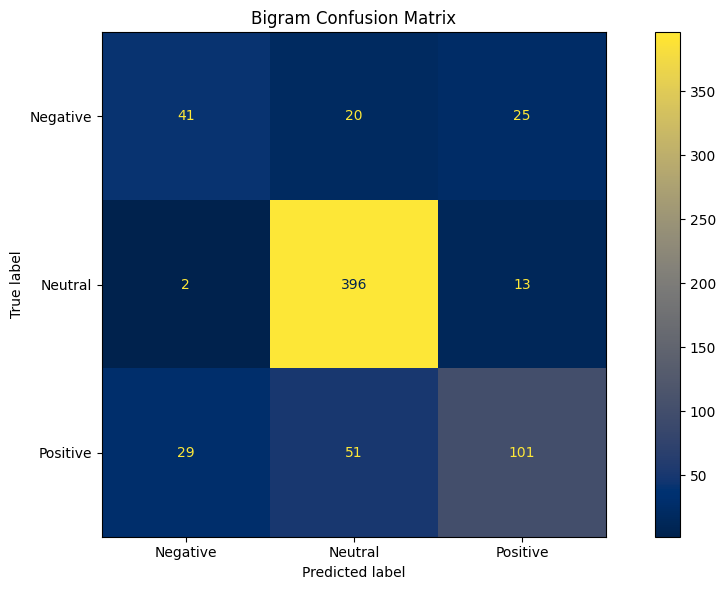

In [30]:
# Create the Bigram Confusion Matrix
cm = confusion_matrix(y_test, y_pred_bigram)
fig, ax = plt.subplots(figsize=(10,6))

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Negative", "Neutral", "Positive"])

# Construct the Bigram Confusion Matrix
disp.plot(cmap="cividis", ax=ax)
plt.title("Bigram Confusion Matrix")
plt.tight_layout()
plt.savefig("sentiment_visuals/bigram_confusion_matrix")
plt.show()

The number of neutral predictions is about the same, but it seems the model has more predictions for neutral labels when actual sentiment is positive or negative. The number of correct predictions for positive and negative sentiment has decreased compared to the unigram model.

### SHAP Visualization

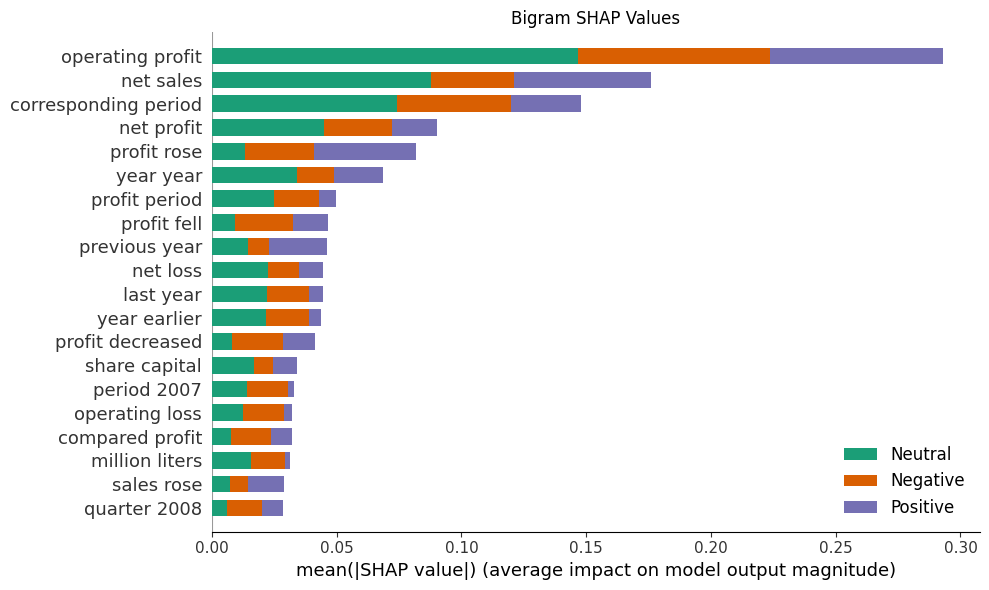

In [31]:
# Compute SHAP values for the Bigram Model
X_bigram = model_bigram.named_steps["tfidf"].transform(X_test)
explainer_bigram = shap.Explainer(model_bigram.named_steps["clf"], X_bigram)
shap_values_bigram = explainer_bigram(X_bigram)

# Visualize Bigram SHAP values
shap.summary_plot(shap_values_bigram, 
                  features=X_bigram, 
                  feature_names=model_bigram.named_steps["tfidf"].get_feature_names_out(),
                  class_names=["Negative", "Neutral", "Positive"],
                  color=plt.get_cmap("Dark2"),
                  show=False)

plt.gcf().set_size_inches(10, 6)
plt.title("Bigram SHAP Values")
plt.tight_layout()
plt.savefig("sentiment_visuals/bigram_shap")
plt.show()

- Financial metrics appear to be the greatest contributors towards this model's predictions. Time anchors are now more specific, narrowing down time periods to certain months of certain years. 
- Directional indicators can now be combined with financial metrics, clearly indicating how movements of those metrics may contribute to sentiment. Sales rose and profit fell contribute most to positive and negative sentiment respective, which is to be expected.
- Using bigrams also introduces certain financial metrics that consist of 2 words like net profit or operating profit. The bigram year year looks strange, but should refer to year-on-year, which measures changes in a metric from one year to another. This phrase is incorrectly placed here, likely due to stopword cleaning removing the word 'on.'

## Trigram

### Model Pipeline

In [32]:
# Build the Trigram Model Pipeline
model_trigram= Pipeline([
    ("tfidf", TfidfVectorizer(max_features=3000, stop_words=custom_stopwords, ngram_range=(3, 3))),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced")) # weight applied since data is imbalanced
])

# Fit the Trigram Model
model_trigram.fit(X_train, y_train)

# Make predictions with the Trigram Model
y_pred_trigram = model_trigram.predict(X_test)

### Classification Report

In [33]:
# Classification Report
print(classification_report(y_test, y_pred_trigram, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.53      0.23      0.32        86
     Neutral       0.71      1.00      0.83       411
    Positive       0.83      0.29      0.43       181

    accuracy                           0.71       678
   macro avg       0.69      0.51      0.53       678
weighted avg       0.72      0.71      0.66       678



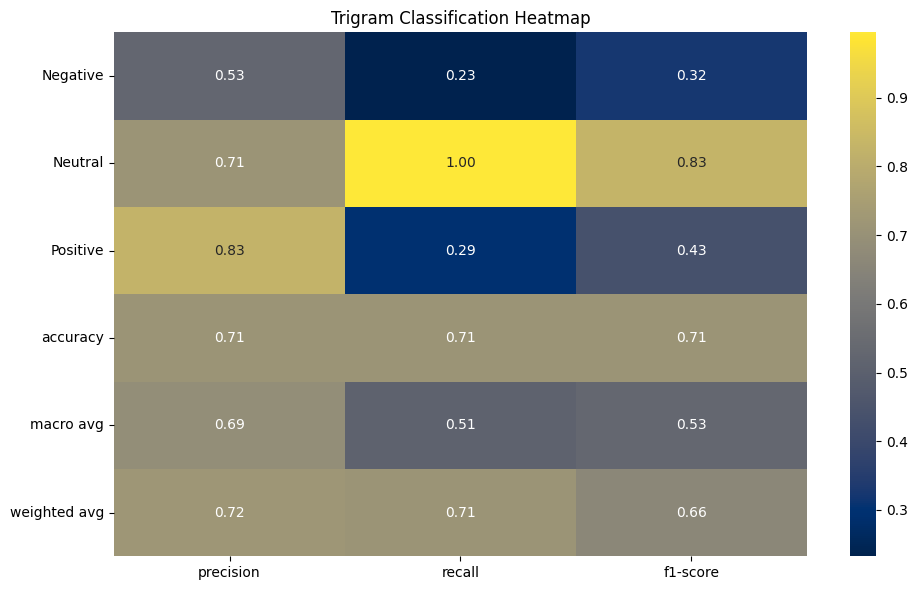

In [34]:
# Save Classification Report as dataframe and transpose
report_dict_trigram = classification_report(y_test, y_pred_trigram, target_names=["Negative", "Neutral", "Positive"], output_dict=True)
report_df_trigram = pd.DataFrame(report_dict_trigram).transpose()

# Drop support column
report_df_trigram = report_df_trigram.drop(columns=["support"])

# Construct the Trigram Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df_trigram, annot=True, cmap="cividis", fmt=".2f")
plt.title("Trigram Classification Heatmap")
plt.tight_layout()
plt.savefig("sentiment_visuals/trigram_classification_heatmap")
plt.show()

Overall accuracy with this model is even lower than the bigram model. While this model shows increased precision for positive sentiment and increased recall for neutral sentiment, performance otherwise appears worse. This is especially the case for neutral sentiment, where recall dropped by over 50%.

### Confusion Matrix

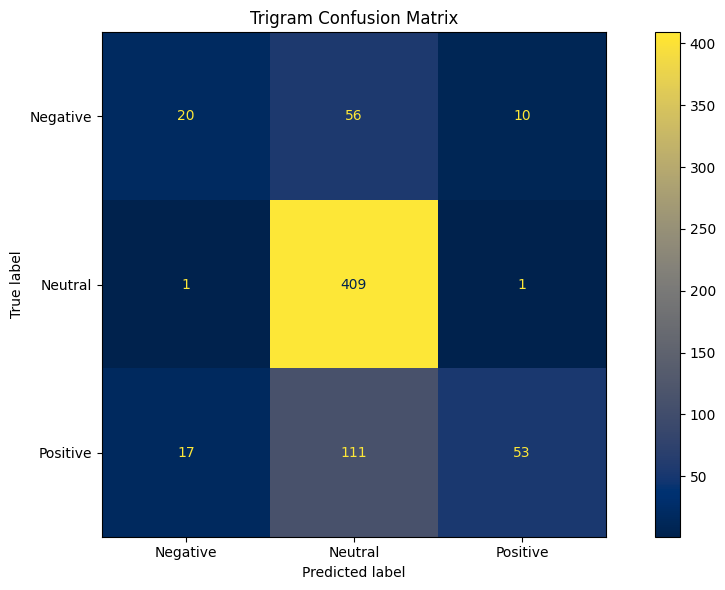

In [35]:
# Create the Trigram Confusion Matrix
cm = confusion_matrix(y_test, y_pred_trigram)
fig, ax = plt.subplots(figsize=(10,6))

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Negative", "Neutral", "Positive"])

# Construct the Trigram Confusion Matrix
disp.plot(cmap="cividis", ax=ax)
plt.title("Trigram Confusion Matrix")
plt.tight_layout()
plt.savefig("sentiment_visuals/trigram_confusion_matrix")
plt.show()

From the confusion matrix, we observe greater frequencies of neutral predictions from the model, indicating more extreme bias towards neutral sentiment than the previous models.

### SHAP Visualization

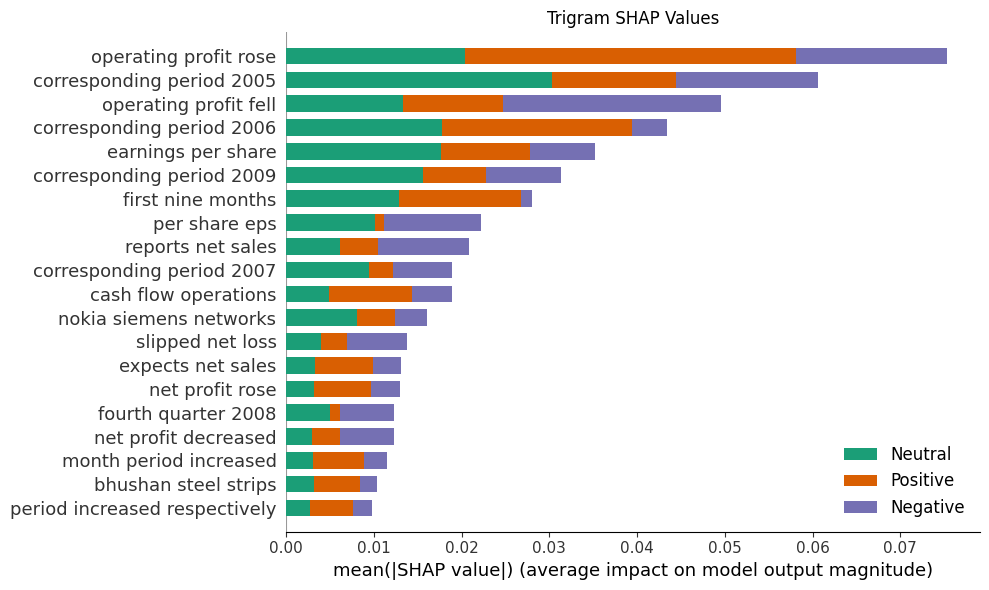

In [36]:
# Compute SHAP values for the Trigram Model
X_trigram = model_trigram.named_steps["tfidf"].transform(X_test)
explainer_trigram = shap.Explainer(model_trigram.named_steps["clf"], X_trigram)
shap_values_trigram = explainer_trigram(X_trigram)

# Visualize Trigram SHAP values
shap.summary_plot(shap_values_trigram, 
                  features=X_trigram, 
                  feature_names=model_trigram.named_steps["tfidf"].get_feature_names_out(),
                  class_names=["Negative", "Neutral", "Positive"],
                  color=plt.get_cmap("Dark2"),
                  show=False)

plt.gcf().set_size_inches(10, 6)
plt.title("Trigram SHAP Values")
plt.tight_layout()
plt.savefig("sentiment_visuals/trigram_shap")
plt.show()

- With trigrams, certain bigram financial metrics can now be combined with directional indicators. 
- The top contributors are directionally indicated financials and time periods.
- Time period trigrams appear rather frequently and mostly contribute to neutral sentiment.
- Model performance may improve if those temporal anchors were removed from the model. 

## N-Gram (1-5 words)

### Model Pipeline

In [37]:
# Build the N-Gram Model Pipeline
model_ngram = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=3000, stop_words=custom_stopwords, ngram_range=(1, 5))),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced")) # weight applied since data is imbalanced
])

# Fit the N-Gram Model
model_ngram.fit(X_train, y_train)

# Make predictions with the N-Gram Model
y_pred_n = model_ngram.predict(X_test)

### Classification Report

In [38]:
# Classification Report
print(classification_report(y_test, y_pred_n, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.63      0.63      0.63        86
     Neutral       0.89      0.95      0.92       411
    Positive       0.76      0.64      0.70       181

    accuracy                           0.83       678
   macro avg       0.76      0.74      0.75       678
weighted avg       0.82      0.83      0.82       678



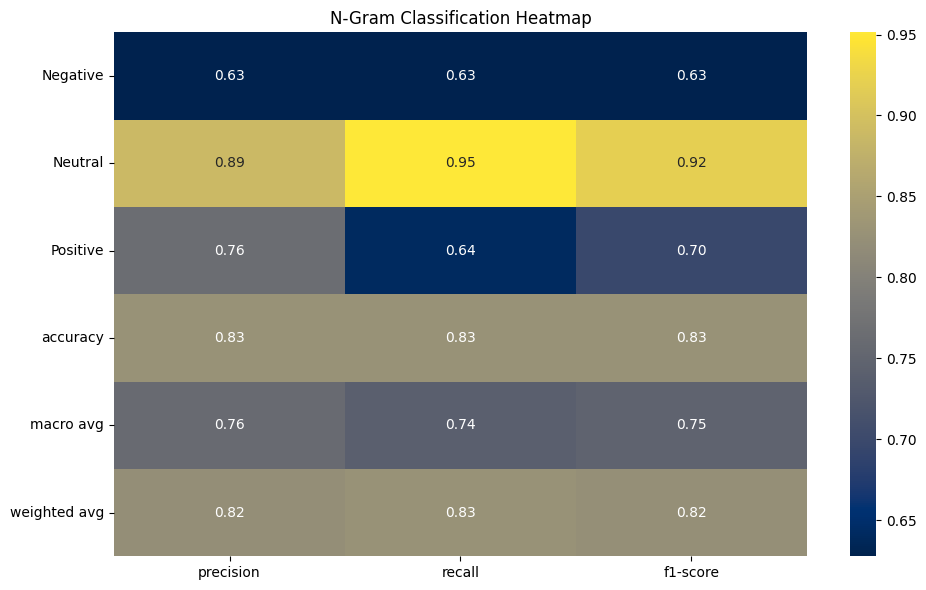

In [39]:
# Save Classification Report as dataframe and transpose
report_dict_n = classification_report(y_test, y_pred_n, target_names=["Negative", "Neutral", "Positive"], output_dict=True)
report_df_n = pd.DataFrame(report_dict_n).transpose()

# Drop support column
report_df_n = report_df_n.drop(columns=["support"])

# Construct the N-gram Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df_n, annot=True, cmap="cividis", fmt=".2f")
plt.title("N-Gram Classification Heatmap")
plt.tight_layout()
plt.savefig("sentiment_visuals/ngram_classification_heatmap")
plt.show()

Compared to the unigram model: 
- Changes of 3 to 5 percent are observed for positive sentiment, with a decrease in precision and an increase in recall. 
- For other sentiment and metrics, there is little to no difference in performance.
- Overall accuracy is the same.

### Confusion Matrix

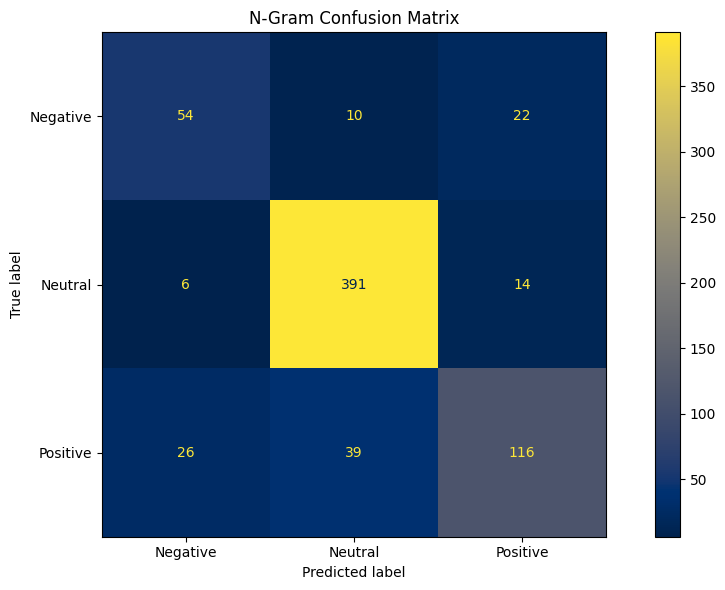

In [40]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_n)
fig, ax = plt.subplots(figsize=(10,6))

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Negative", "Neutral", "Positive"])

# Construct the N-Gram Confusion Matrix
disp.plot(cmap="cividis", ax=ax)
plt.title("N-Gram Confusion Matrix")
plt.tight_layout()
plt.savefig("sentiment_visuals/ngram_confusion_matrix")
plt.show()

### SHAP Visualization

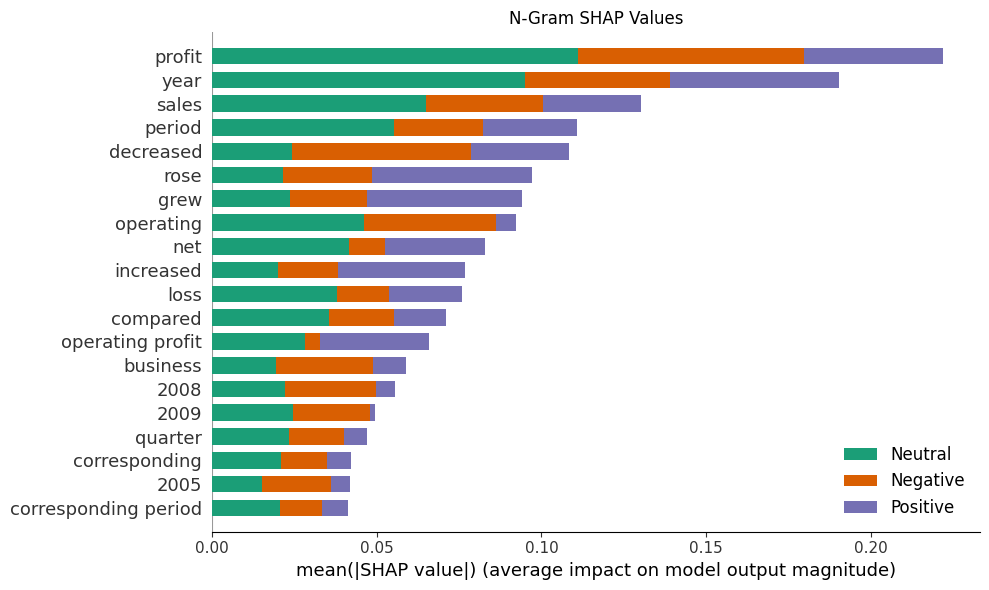

In [41]:
# Compute SHAP values for the N-Gram Model
X_ngram = model_ngram.named_steps["tfidf"].transform(X_test)
explainer_ngram = shap.Explainer(model_ngram.named_steps["clf"], X_ngram)
shap_values_ngram = explainer_ngram(X_ngram)

# Visualize N-Gram SHAP values
shap.summary_plot(shap_values_ngram, 
                  features=X_ngram, 
                  feature_names=model_ngram.named_steps["tfidf"].get_feature_names_out(),
                  class_names=["Negative", "Neutral", "Positive"],
                  color=plt.get_cmap("Dark2"),
                  show=False)

plt.gcf().set_size_inches(10, 6)
plt.title("N-Gram SHAP Values")
plt.tight_layout()
plt.savefig("sentiment_visuals/ngram_shap")
plt.show()

- Unigrams contribute the most towards model predictions. 
- Corresponding and corresponding period are both in the plot. The word corresponding overlaps and is rather redundant.
- Profit and sales are the highest contributing financial metrics to the model's sentiment predictions.

# Insights

- In this dataset, unigrams contributed the most to best performing models.
- Allowing the model to check for N-grams, including but not limited to the unigrams, does not affect model performance much for Negative and Neutral sentiment, but does have an observable increase in recall for Positive sentiment.
- The N-gram model retains the same level of performance for negative and neutral sentiment in the unigram baseline, while providing a slight boost in Positive recall and clearer SHAP interpretability at the expense of Positive precision.
- The data may contain noise that makes the model biased towards Neutral sentiment. Temporal anchors are suspected to be responsible.

# Next steps

- Explore potential length bias across sentiment classes by normalizing TF-IDF by document length or including word count as a feature.
- Explore different random seeds and/or resample the data before modeling.
- Increase proportion of training data when splitting, changing the 70/30 split to an 80/20 split. Since the dataset is small, model performance may change by increasing the sample size of the training data.
- Adjust cleaning to exclude certain financial phrases like year-on-year.
- Account for overlapping words when modeling n-grams. This would also require steps to excluded terms like operating profit or net profit from the process, since those are specific financial terms rather than actual overlap.
- Try removing temporal anchors and check for any changes in model performance as those terms may be noise.
- Fit different models using other N-gram ranges such as 1-3 words or 2-5 words and compare the models' performance to the Unigram model.